In [ ]:
import tensorflow as tf
import tensorflow_datasets as tds
import PIL 
import numpy as np
import pandas as pd
import scipy 
print(tf.__version__, tds.__version__, PIL.__version__, np.__version__, pd.__version__, scipy.__version__)

2.9.0 4.6.0 8.4.0 1.22.4 1.4.2 1.7.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tạo hàm hỗ trợ

In [1]:
# Lấy file hàm hỗ trợ
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import chuỗi các hàm hỗ trợ cho notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-03-04 07:26:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-04 07:26:07 (75.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [14]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download và tiền sử lý dữ liệu

In [4]:
unzip_data('/content/drive/MyDrive/data_40_percent.zip')

In [5]:
train_dir = '/content/data/train'
val_dir = '/content/data/validation'

In [89]:
walk_through_dir('data')

There are 2 directories and 0 images in 'data'.
There are 101 directories and 0 images in 'data/validation'.
There are 0 directories and 40 images in 'data/validation/filet_mignon'.
There are 0 directories and 40 images in 'data/validation/grilled_salmon'.
There are 0 directories and 40 images in 'data/validation/paella'.
There are 0 directories and 40 images in 'data/validation/garlic_bread'.
There are 0 directories and 40 images in 'data/validation/cannoli'.
There are 0 directories and 40 images in 'data/validation/sushi'.
There are 0 directories and 40 images in 'data/validation/escargots'.
There are 0 directories and 40 images in 'data/validation/tacos'.
There are 0 directories and 40 images in 'data/validation/pizza'.
There are 0 directories and 40 images in 'data/validation/red_velvet_cake'.
There are 0 directories and 40 images in 'data/validation/sashimi'.
There are 0 directories and 40 images in 'data/validation/lasagna'.
There are 0 directories and 40 images in 'data/validati

## Hiển thị ảnh ngẫu nhiên

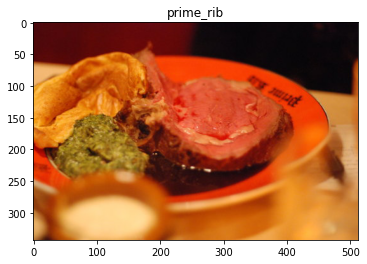

Image has shape: (343, 512, 3)


In [7]:
random_class = random.choice(os.listdir(train_dir))
random_class_dir = os.path.join(train_dir, random_class)
random_img_dir = random.choice(os.listdir(random_class_dir))
random_img = os.path.join(random_class_dir, random_img_dir)

img = load_img(random_img)
plt.imshow(img)
plt.title(random_class)
plt.show()

print(f"Image has shape: {img_to_array(img).shape}")

## Training and Validation Generators

In [8]:
# Train dataset
train_datagen = ImageDataGenerator(
    #rescale=1.0/255, # Giữ cho ResNet50V2, bỏ cho EfficientNetB0
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224,224),)
# Validation dataset 
val_datagen = ImageDataGenerator(
    #rescale=1.0/255, # Giữ cho ResNet50V2, bỏ cho EfficientNetB0
)

val_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                batch_size=64,
                                                class_mode='categorical',
                                                target_size=(224,224),
                                                shuffle=False)

Found 36360 images belonging to 101 classes.
Found 4040 images belonging to 101 classes.


In [ ]:
class_dict = val_generator.class_indices
class_names = list(class_dict.keys())
class_names

In [10]:
num_classes = train_generator.num_classes
num_classes

101

In [11]:
train_generator, val_generator

(<keras.preprocessing.image.DirectoryIterator at 0x7fbfaa60bd90>,
 <keras.preprocessing.image.DirectoryIterator at 0x7fbfaa60bb50>)

# Tạo model và huấn luyện

## Model CNN đơn giản

In [ ]:
base_model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
base_model.compile(optimizer=RMSprop(),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
num_epochs = 1
base_history = base_model.fit(train_generator,
                              epochs=num_epochs,
                              validation_data=val_generator)

3081/3081 [==============================] - 1565s 507ms/step - loss: 4.6255 - accuracy: 0.0092 - val_loss: 4.6152 - val_accuracy: 0.0099


## Tranfer learning with model EfficientNetB0

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

#local_weights_file = '/content/drive/MyDrive/efficientnet-b7_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'

pretrained_model = EfficientNetB0(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')
#effb7_model.load_weights(local_weights_file)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
for layer in pretrained_model.layers:
  layer.trainable = False
pretrained_model.summary()

### Tạo layer mong muốn ở trong pretrained model

In [ ]:
last_desired_layer = pretrained_model.get_layer('top_activation')
print('last layer output shape: ', last_desired_layer.output_shape)
last_output_layer = last_desired_layer.output
print('last layer output: ', last_output_layer)

last layer output shape:  (None, 7, 7, 1280)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='top_activation/IdentityN:0', description="created by layer 'top_activation'")


### Create tranfer model

In [ ]:
x = layers.GlobalMaxPooling2D(name='global_max_pooling')(last_output_layer)
x = layers.Dense(640, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

tranfer_model = Model(inputs=pretrained_model.input, outputs=x)

In [ ]:
tranfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

## Định nghĩa một số callbacks

In [ ]:
# Dừng train khi accuracy đạt 70% 
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_stop(self, epoch, logs={}):
    if logs.get('accuracy') > 0.7:
      print("\nReached 70% accuracy so cancelling training!")
      self.model.stop_training = True
on_epoch_stop = myCallback()

# Dừng train khi val_loss không cải thiện sau 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)
# Tăng 10 lần learning_rate sau 20 epochs 
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6*10**(epoch/20))

In [ ]:
# Tạo checkpoint callback để lưu tiến trình mô hình 
checkpoint_path = '/content/drive/MyDrive/checkpoint_CV/tranfer_EfficientNetB0/cp.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)
tranfer_epochs = 5
tranfer_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
tranfer_history = tranfer_model.fit(train_generator,
                                    epochs=tranfer_epochs,
                                    validation_data=val_generator,
                                    callbacks=[on_epoch_stop, checkpoint_callback, early_stopping])

Epoch 1/5
569/569 [==============================] - 669s 1s/step - loss: 3.4482 - accuracy: 0.2098 - val_loss: 2.4029 - val_accuracy: 0.3933
Epoch 2/5
569/569 [==============================] - 628s 1s/step - loss: 2.5806 - accuracy: 0.3553 - val_loss: 2.1271 - val_accuracy: 0.4574
Epoch 3/5
569/569 [==============================] - 625s 1s/step - loss: 2.4007 - accuracy: 0.3953 - val_loss: 2.0097 - val_accuracy: 0.4874
Epoch 4/5
569/569 [==============================] - 638s 1s/step - loss: 2.3066 - accuracy: 0.4155 - val_loss: 1.9757 - val_accuracy: 0.4955
Epoch 5/5
569/569 [==============================] - 623s 1s/step - loss: 2.2612 - accuracy: 0.4232 - val_loss: 1.9387 - val_accuracy: 0.5012


In [ ]:
result_tranfer_model = tranfer_model.evaluate(val_generator)
result_tranfer_model

64/64 [==============================] - 24s 369ms/step - loss: 1.9387 - accuracy: 0.5012


[1.938715934753418, 0.5012376308441162]

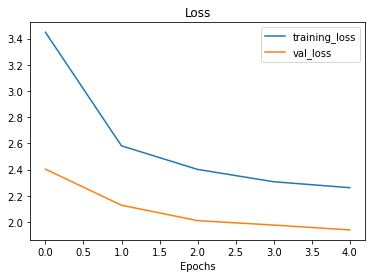

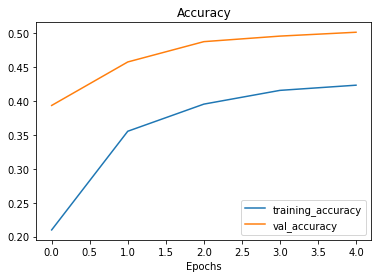

In [ ]:
plot_loss_curves(tranfer_history)

In [ ]:
tranfer_model.save('/content/drive/MyDrive/save_model_CV/tranfer_EfficientNetB0')

# Fine turning model

In [ ]:
fine_tune_model = tf.keras.models.load_model('/content/drive/MyDrive/save_model_CV/tranfer_EfficientNetB0')

In [ ]:
for layer in fine_tune_model.layers[-12:]:
  layer.trainable = True

In [ ]:
for i,layer in enumerate(fine_tune_model.layers):
  if layer.trainable:
    print(i, layer.name)

0 input_1
230 block7a_se_reduce
231 block7a_se_expand
232 block7a_se_excite
233 block7a_project_conv
234 block7a_project_bn
235 top_conv
236 top_bn
237 top_activation
238 global_max_pooling
239 dense
240 dropout
241 dense_1


In [ ]:
fine_tune_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [ ]:
fine_tune_model.evaluate(val_generator)

64/64 [==============================] - 26s 373ms/step - loss: 1.9387 - accuracy: 0.5012


[1.9387158155441284, 0.5012376308441162]

In [ ]:
# Tạo checkpoint callback để lưu tiến trình mô hình 
checkpoint_path = '/content/drive/MyDrive/checkpoint_CV/fine_tune/cp.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)
fine_tune_epochs = 15
fine_tune_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
fine_tune_history = fine_tune_model.fit(train_generator,
                                        epochs=fine_tune_epochs,
                                        validation_data=val_generator,
                                        callbacks=[on_epoch_stop, checkpoint_callback, early_stopping],
                                        initial_epoch=tranfer_history.epoch[-1])

Epoch 5/15
569/569 [==============================] - 640s 1s/step - loss: 2.1786 - accuracy: 0.4470 - val_loss: 1.7009 - val_accuracy: 0.5547
Epoch 6/15
569/569 [==============================] - 622s 1s/step - loss: 1.9391 - accuracy: 0.4983 - val_loss: 1.6267 - val_accuracy: 0.5802
Epoch 7/15
569/569 [==============================] - 630s 1s/step - loss: 1.8036 - accuracy: 0.5278 - val_loss: 1.5546 - val_accuracy: 0.6025
Epoch 8/15
569/569 [==============================] - 625s 1s/step - loss: 1.7045 - accuracy: 0.5511 - val_loss: 1.5123 - val_accuracy: 0.6059
Epoch 9/15
569/569 [==============================] - 627s 1s/step - loss: 1.6454 - accuracy: 0.5641 - val_loss: 1.4294 - val_accuracy: 0.6304
Epoch 10/15
569/569 [==============================] - 632s 1s/step - loss: 1.5652 - accuracy: 0.5827 - val_loss: 1.4855 - val_accuracy: 0.6233
Epoch 11/15
569/569 [==============================] - 635s 1s/step - loss: 1.5025 - accuracy: 0.5980 - val_loss: 1.4257 - val_accuracy: 0.63

In [ ]:
result_fine_tune_model = fine_tune_model.evaluate(val_generator)
result_fine_tune_model

64/64 [==============================] - 25s 392ms/step - loss: 1.3844 - accuracy: 0.6517


[1.384444236755371, 0.6517326831817627]

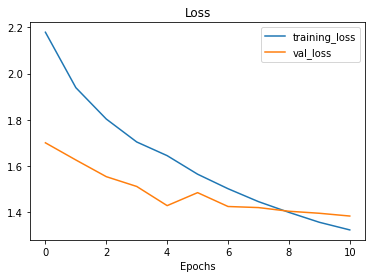

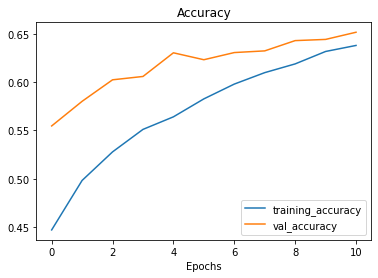

In [ ]:
plot_loss_curves(fine_tune_history)

In [ ]:
fine_tune_model.save('/content/drive/MyDrive/save_model_CV/fine_tune_model')

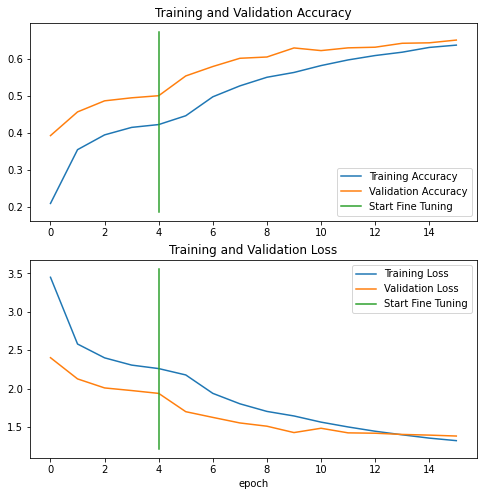

In [ ]:
compare_historys(tranfer_history, fine_tune_history)

# Xuất mô hình

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [18]:
model = tf.keras.models.load_model('/content/drive/MyDrive/save_model_CV/fine_tune_model')

In [22]:
# xác suất dự đoán
pred_probs = model.predict(val_generator, verbose=1)
pred_probs

64/64 [==============================] - 29s 393ms/step


array([[7.12911427e-01, 3.54423719e-05, 6.91983709e-03, ...,
        1.66706770e-04, 7.03076523e-07, 1.26099229e-01],
       [1.09614834e-01, 1.71106640e-05, 3.37609835e-02, ...,
        1.87887158e-03, 1.10165282e-04, 1.26111822e-03],
       [5.87425120e-02, 6.85860505e-06, 3.97470504e-01, ...,
        2.54711108e-06, 5.65811805e-03, 8.54760219e-05],
       ...,
       [6.62775710e-03, 8.27905660e-06, 1.71398369e-05, ...,
        1.03456682e-06, 5.89768163e-08, 9.75975275e-01],
       [2.02851649e-03, 6.88041386e-04, 2.39210832e-03, ...,
        4.20873351e-02, 4.65656212e-03, 4.58942592e-01],
       [8.79576355e-02, 4.91660066e-05, 2.13883389e-02, ...,
        1.86736844e-02, 9.54752759e-05, 1.54077128e-01]], dtype=float32)

In [23]:
pred_probs.shape

(4040, 101)

In [24]:
# Chúng ta thu được một dự đoán xác suất mỗi lớp
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [7.12911427e-01 3.54423719e-05 6.91983709e-03 5.00101180e-07
 4.25284469e-07 2.10480891e-07 5.77293045e-04 2.42106609e-07
 4.05400321e-02 6.77482167e-05 3.12063207e-06 1.33640725e-07
 1.66182255e-03 1.55126008e-06 1.68946353e-04 7.12405992e-08
 1.91719628e-05 2.29475540e-04 1.21763980e-04 7.40388805e-06
 8.86699563e-05 8.61268127e-05 8.08529658e-05 7.70924380e-04
 2.45084557e-05 2.31321433e-08 5.43789201e-06 6.01852138e-04
 9.84227285e-04 6.65741798e-04 4.48565800e-07 9.14617092e-04
 6.85243960e-03 4.81143081e-09 1.73035616e-04 1.62359953e-04
 3.77695119e-06 2.89815603e-07 3.50511778e-04 4.42664314e-05
 8.35484479e-06 5.24622446e-04 1.38986427e-02 2.67117484e-05
 2.38504072e-07 3.66987224e-05 1.49630068e-04 8.87733622e-05
 5.16587377e-08 1.62925862e-05 1.40321681e-05 4.34561343e-07
 1.28347678e-02 1.00882957e-04 2.29413508e-05 1.20490940e-05
 2.78790190e-04 9.74397990e-05 1.02575962e-

In [25]:
# lớp của các dự đoán
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0, 59,  2,  0,  0,  0,  0,  2,  2,  0])

In [49]:
val_labels = val_generator.labels
len(val_labels)

4040

In [50]:
val_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [53]:
from sklearn.metrics import accuracy_score, classification_report
sklearn_accuracy = accuracy_score(val_labels, pred_classes)
sklearn_accuracy

0.6517326732673268

In [54]:
# Tạo dict classification report
classification_report_dict = classification_report(val_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3404255319148936,
  'recall': 0.4,
  'f1-score': 0.36781609195402304,
  'support': 40},
 '1': {'precision': 0.5813953488372093,
  'recall': 0.625,
  'f1-score': 0.6024096385542168,
  'support': 40},
 '2': {'precision': 0.4782608695652174,
  'recall': 0.825,
  'f1-score': 0.6055045871559632,
  'support': 40},
 '3': {'precision': 0.71875,
  'recall': 0.575,
  'f1-score': 0.6388888888888888,
  'support': 40},
 '4': {'precision': 0.7777777777777778,
  'recall': 0.525,
  'f1-score': 0.6268656716417911,
  'support': 40},
 '5': {'precision': 0.5666666666666667,
  'recall': 0.425,
  'f1-score': 0.48571428571428565,
  'support': 40},
 '6': {'precision': 0.8611111111111112,
  'recall': 0.775,
  'f1-score': 0.8157894736842106,
  'support': 40},
 '7': {'precision': 0.9393939393939394,
  'recall': 0.775,
  'f1-score': 0.8493150684931509,
  'support': 40},
 '8': {'precision': 0.5333333333333333,
  'recall': 0.4,
  'f1-score': 0.4571428571428572,
  'support': 40},
 '9': {'precis

In [85]:
# Chỉ lấy f1 score và tạo dataframe
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == 'accuracy': break
  else: class_f1_scores[class_names[int(k)]] = v['f1-score']
import pandas as pd
f1_scores = pd.DataFrame({'class_name': list(class_f1_scores.keys()),
                         'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.948718
88,seaweed_salad,0.926829
27,creme_brulee,0.921053
63,macarons,0.909091
45,frozen_yogurt,0.897436
...,...,...
50,grilled_salmon,0.347826
93,steak,0.342105
77,pork_chop,0.342105
22,chocolate_mousse,0.317460


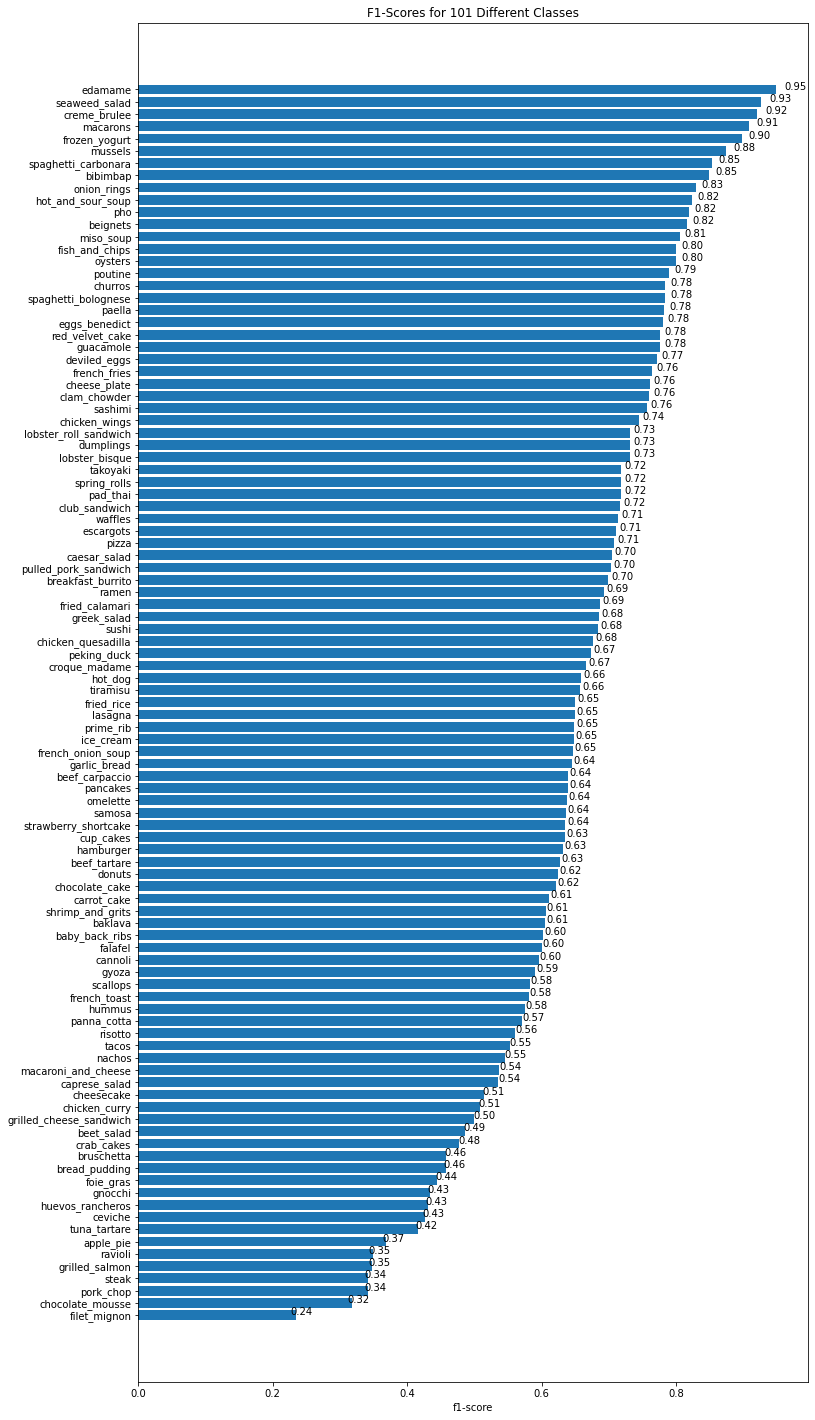

In [86]:
# Trực quan hóa f1 score cho 101 lớp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis(); # đảo ngược thứ tự

def autolabel(rects): 
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

- Dữ liệu dự đoán tốt trên các lớp edamane (đậu nành luộc), seaweed_salad (slad rong biển), creme_brulee (kem cháy)
- Nhưng dự đoán rất tệ với filet_mignon (thịt thăn filet), chocolate_mousse, pork_chop...
- Chúng ta cần thêm ảnh đào tạo cho các lớp phân loại kém, khó đào tạo 

# Dự đoán trên ảnh thật

In [60]:
class_names = ['apple_pie','baby_back_ribs','baklava','beef_carpaccio','beef_tartare','beet_salad','beignets','bibimbap','bread_pudding','breakfast_burrito','bruschetta','caesar_salad','cannoli','caprese_salad','carrot_cake','ceviche','cheese_plate','cheesecake','chicken_curry','chicken_quesadilla','chicken_wings','chocolate_cake','chocolate_mousse','churros','clam_chowder','club_sandwich','crab_cakes','creme_brulee','croque_madame','cup_cakes','deviled_eggs','donuts','dumplings','edamame','eggs_benedict','escargots','falafel','filet_mignon','fish_and_chips','foie_gras','french_fries','french_onion_soup','french_toast','fried_calamari','fried_rice','frozen_yogurt','garlic_bread','gnocchi','greek_salad','grilled_cheese_sandwich','grilled_salmon','guacamole','gyoza','hamburger','hot_and_sour_soup','hot_dog','huevos_rancheros','hummus','ice_cream','lasagna','lobster_bisque','lobster_roll_sandwich','macaroni_and_cheese','macarons','miso_soup','mussels','nachos','omelette','onion_rings','oysters','pad_thai','paella','pancakes','panna_cotta','peking_duck','pho','pizza','pork_chop','poutine','prime_rib','pulled_pork_sandwich','ramen','ravioli','red_velvet_cake','risotto','samosa','sashimi','scallops','seaweed_salad','shrimp_and_grits','spaghetti_bolognese','spaghetti_carbonara','spring_rolls','steak','strawberry_shortcake','sushi','tacos','takoyaki','tiramisu','tuna_tartare','waffles']

In [79]:
def predict_img(model, img_path=''):
  img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  true_name = img_path.split('/')[-1].split('.')[0]
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  predict_name = class_names[np.argmax(score)]
  plt.imshow(img)
  if predict_name == true_name:
    plt.title(f'Predict: {predict_name}, True_name: {true_name}', color='g')
  else:
    plt.title(f'Predict: {predict_name}, True_name: {true_name}', color='r')
  plt.show()

1/1 [==============================] - 0s 34ms/step


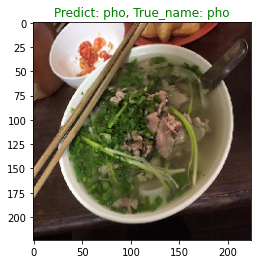

In [80]:
predict_img(model, '/content/drive/MyDrive/pho.jpg')

1/1 [==============================] - 0s 31ms/step


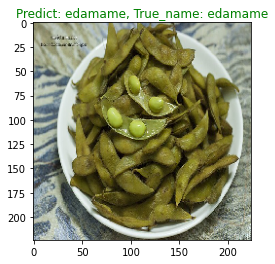

In [81]:
predict_img(model, '/content/drive/MyDrive/edamame.jpg')

1/1 [==============================] - 0s 31ms/step


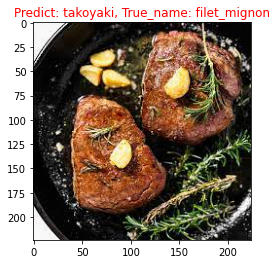

In [82]:
predict_img(model, '/content/drive/MyDrive/filet_mignon.jpg')

1/1 [==============================] - 0s 123ms/step


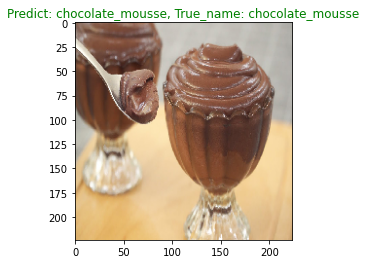

In [83]:
predict_img(model, '/content/drive/MyDrive/chocolate_mousse.jpg')

1/1 [==============================] - 0s 78ms/step


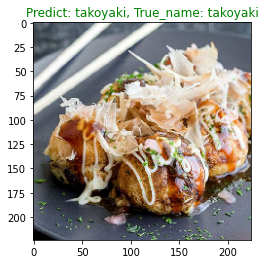

In [84]:
predict_img(model, '/content/drive/MyDrive/takoyaki.jpg')

1/1 [==============================] - 0s 76ms/step


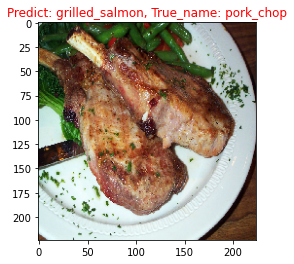

In [88]:
predict_img(model, '/content/drive/MyDrive/pork_chop.png')